In [1]:
# -*- coding: utf-8 -*-
import sys
import os       
import pandas as pd
import datetime
os.chdir('D:/zxdf/Workspaces/PycharmProjects/flask_ml')
from app import config, Elasticsearch_Util

starttime = datetime.datetime.now()
print ("当前的日期和时间是 %s" % starttime)

In [2]:
def getDataFromES(es_util, index, type, beginTime, endTime, fromnum, size, source_include):
    # 最大查询10000条数据
    query_data = {
        "from": fromnum,
        "size": size,
        "query": {
            "bool": {
                "must": [
                    {
                        "range": {
                            "@timestamp": {
                                "from": beginTime,
                                "to": endTime
                            }
                        }
                    }
                ],
            }
        },
        "_source": {
            "includes": source_include,
            "excludes": []
        },
        "sort": [
            {
                "@timestamp": {
                    "order": "desc"
                }
            }
        ]
    }
    res = es_util.query(index, type, query_data)
    df = None
    records = []
    for doc in res['hits']['hits']:
        records.append(doc['_source'])
    if records:
        df = pd.DataFrame(records)
    return df

In [3]:
from sklearn.preprocessing import LabelEncoder
index = "1012-knowledge_training-*"
type = "knowledge_training"
beginTime = "2018-01-26T00:00:00.000+08:00"
endTime = "2018-01-27T00:00:00.000+08:00"
fromnum = 0
size = 1608
#1085  804:281
tag = "isException"
logmsg = "logBody"
source_include = [tag, logmsg]

es_util = Elasticsearch_Util()
train_data = getDataFromES(es_util, index=index, type=type,
                           beginTime=beginTime, endTime=endTime,
                           fromnum=fromnum, size=size,
                           source_include=source_include)
feature_data_array = train_data[logmsg]
class_data_array = train_data[tag]
print len(feature_data_array)
print len(class_data_array)
# 将类别转化为数字标签
#le = LabelEncoder()
#train_labelValues = le.fit_transform(class_data_array)

In [4]:
#train_data.head(10)

In [5]:
import nltk
import string
from nltk.corpus import stopwords
#from nltk.stem.porter import *

#训练数据关键词提取列表
def tokenize(text):
    #f = open(r"E:\zxdf\ml\linkdata-log\dataset\testrecord\keyword_logbody.txt", "a+")
    tokens = nltk.word_tokenize(text)
    tokens2=[]
    for w in tokens:
        if w[0]=='-':
            tokens2.append(w[1:])
        elif w[0]=="'":
            tokens2.append(w[1:])    
        else:
            tokens2.append(w)
    
    stopword_tokens = [i for i in tokens2 if i not in string.punctuation]
    stopword_tokens2 = [w for w in stopword_tokens if w not in stopwords.words('english')]
    
    stopwords_custom=["''", "``","||","'/","'/'",u"'0x0","'2","'=","'s",'**','***','***.***','**constraint.unique_wt**','**failed','**method','--',
                      '-1','-297991290629036654','-614','-6182496564283649260','-6787310117729693199','-8','-999999999',u'-e',
                      '..','...','.\\xxx\\xxx.txt','/*','/**','/c','/p','0','1','==','b','c','e','x','===',
                      'v'
                     ]
    #,'mapped'
    stopword_tokens3 = [w for w in stopword_tokens2 if w not in stopwords_custom]    
            
    #print >> f, "%s" %(stopword_tokens3) 
    #f.close()
    return stopword_tokens3

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(tokenizer=tokenize, stop_words='english', decode_error='ignore')
csr_mat = vectorizer.fit_transform(feature_data_array)
# 获取词袋模型中的所有词
#wordlist = vectorizer.get_feature_names()  
# tf矩阵 元素a[i][j]表示j词在i类文本中的tf
#countlist = csr_mat.toarray()

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer=TfidfTransformer()
feature_datas= tf_transformer.fit_transform(csr_mat)
#weighttlist = feature_datas.toarray()

In [8]:
feature_datas.todense()
#weighttlist

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
esdatadf=pd.DataFrame(feature_datas.todense())
esdatadf.insert(0,'iserror',class_data_array)

In [11]:
#esdatadf

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

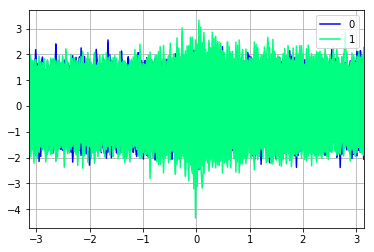

In [17]:
#1.Andrews曲线
#Andrews曲线将每个样本的属性值转化为傅里叶序列的系数来创建曲线。
#通过将每一类曲线标成不同颜色可以可视化聚类数据，属于相同类别的样本的曲线通常更加接近并构成了更大的结构。
from pandas.tools.plotting import andrews_curves
plt.figure()
#colormap='cubehelix',winter,Greens,gist_rainbow

andrews_curves(esdatadf, 'iserror', colormap='winter')

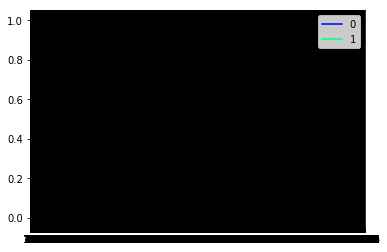

In [18]:
#2.平行坐标
#平行坐标可以看到数据中的类别以及从视觉上估计其他的统计量。
#使用平行坐标时，每个点用线段联接，每个垂直的线代表一个属性，一组联接的线段表示一个数据点。可能是一类的数据点会更加接近。
from pandas.tools.plotting import parallel_coordinates
plt.figure()
parallel_coordinates(esdatadf, 'iserror', colormap='winter')

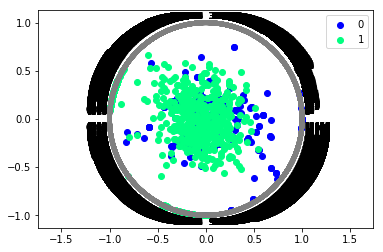

In [19]:
#3.RadViz图
#RadViz图是基于基本的弹簧压力最小化算法（在复杂网络分析中也会经常应用）。简单来说，将一组点放在一个平面上，每一个点代表一个属性。
#上述案例中有四个点，被放在一个单位圆上，你可以设想每个数据集通过一个弹簧联接到每个点上，弹力和他们属性值成正比（属性值已经标准化），
#数据集在平面上的位置是弹簧的均衡位置。不同类的样本用不同颜色表示。
from pandas.tools.plotting import radviz
plt.figure()
radviz(esdatadf, 'iserror', colormap='winter')

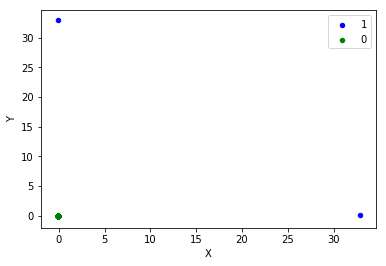

In [17]:
#4.因子分析
#因子分析最初由心理学家斯皮尔曼发明，用于研究人类的人格特质。
#著名的卡特尔16PF（16种相对独立的人格特征）就是应用因素分析方法得来。
#是基于高斯潜在变量的一个简单线性模型，假设每一个观察值都是由低维的潜在变量加正态噪音构成。
from sklearn import decomposition
pca = decomposition.FactorAnalysis(n_components=2)
X = pca.fit_transform(esdatadf.ix[:,1:].values)
pos=pd.DataFrame()
pos['X'] =X[:, 0]
pos['Y'] =X[:, 1]
pos['iserror'] = esdatadf['iserror']
ax = pos.ix[pos['iserror']=='1'].plot(kind='scatter', x='X', y='Y', color='blue', label='1')
ax = pos.ix[pos['iserror']=='0'].plot(kind='scatter', x='X', y='Y', color='green', label='0', ax=ax)

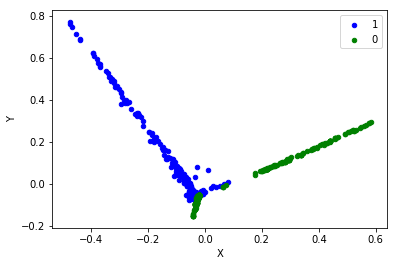

In [28]:
#5.主成分分析
#主成分分析是由因子分析进化而来的一种降维的方法。
#通过正交变换将原始特征转换为线性独立的特征，转换后得到的特征被称为主成分。主成分分析可以将原始维度降维到n个维度。
#有一个特例情况，就是通过主成分分析将维度降低为2维，可以将多维数据转换为平面中的点，来达到多维数据可视化的目的。
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
X = pca.fit_transform(esdatadf.ix[:,1:].values)
pos=pd.DataFrame()
pos['X'] =X[:, 0]
pos['Y'] =X[:, 1]
pos['iserror'] = esdatadf['iserror']
ax = pos.ix[pos['iserror']=='1'].plot(kind='scatter', x='X', y='Y', color='blue', label='1')
ax = pos.ix[pos['iserror']=='0'].plot(kind='scatter', x='X', y='Y', color='green', label='0', ax=ax)
#需要注意，通过PCA降维实际上是损失了一些信息，我们也可以看一下保留的两个主成分可以解释原始数据的多少。

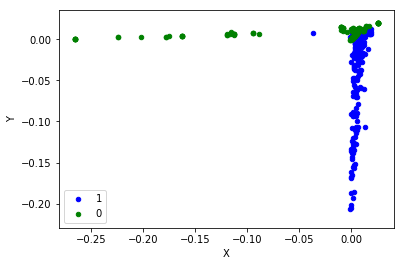

In [20]:
#6.独立成分分析
#独立成分分析将多源信号拆分成较大可能独立性的子成分，它最初不是用来降维，而是用于拆分重叠的信号。
from sklearn import decomposition
pca = decomposition.FastICA(n_components=2)
X = pca.fit_transform(esdatadf.ix[:,1:].values)
pos=pd.DataFrame()
pos['X'] =X[:, 0]
pos['Y'] =X[:, 1]
pos['iserror'] = esdatadf['iserror']
ax = pos.ix[pos['iserror']=='1'].plot(kind='scatter', x='X', y='Y', color='blue', label='1')
pos.ix[pos['iserror']=='0'].plot(kind='scatter', x='X', y='Y', color='green', label='0', ax=ax)

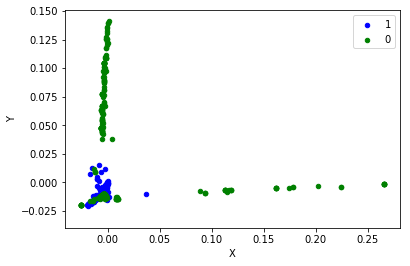

In [35]:
#7.多维尺度分析
#多维尺度分析试图寻找原始高维空间数据的距离的良好低维表征。
#简单来说，多维尺度分析被用于数据的相似性，它试图用几何空间中的距离来建模数据的相似性，即用二维空间中的距离来表示高维空间的关系。
#数据可以是物体之间的相似度、分子之间的交互频率或国家间交易指数，而且是基于欧式距离的距离矩阵。
#多维尺度分析算法是一个不断迭代的过程，因此，需要使用max_iter来指定较大迭代次数，同时计算的耗时也是上面算法中较大的一个。
from sklearn import decomposition
pca = decomposition.FastICA(n_components=3)
X = pca.fit_transform(esdatadf.ix[:,1:].values)
pos=pd.DataFrame()
pos['X'] =X[:, 0]
pos['Y'] =X[:, 1]
pos['iserror'] = esdatadf['iserror']
ax = pos.ix[pos['iserror']=='1'].plot(kind='scatter', x='X', y='Y', color='blue', label='1')
pos.ix[pos['iserror']=='0'].plot(kind='scatter', x='X', y='Y', color='green', label='0', ax=ax)

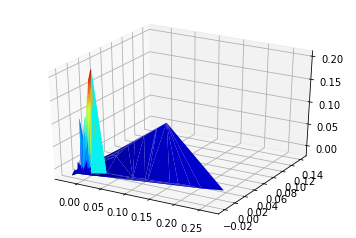

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

x=X[:, 0]
y=X[:, 1]
z=X[:, 2]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x,y,z, cmap=cm.jet, linewidth=0.2)
plt.show()

In [47]:
esdatadf.ix[:,1:]

,0,1,2,3,4,5,6,7,8,9,...,12651,12652,12653,12654,12655,12656,12657,12658,12659,12660
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.707107,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
